In [1]:
import tensorflow as tf
from tensorflow import keras
import time
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.models import Model, load_model
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.neighbors import DistanceMetric
from tslearn.datasets import UCR_UEA_datasets
from tslearn.neighbors import KNeighborsTimeSeries, KNeighborsTimeSeriesClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from counterfactual_utils import label_encoder, ucr_data_loader
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.5.0
Eager execution enabled:  False
TF version:  2.5.0
Eager execution enabled:  False


In [2]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('GunPoint')
y_train, y_test = label_encoder(y_train, y_test)

In [3]:
# fitting the classifier
model = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9066666666666666

In [36]:
#finding the nearest unlike neighbour. NB will need to account for regularization
def native_guide_retrieval(query, predicted_label, distance, n_neighbors):
    
    df = pd.DataFrame(y_train, columns = ['label'])
    df.index.name = 'index'
    #df[df['label'] == 1].index.values, df[df['label'] != 1].index.values
    
    ts_length = X_train.shape[1]
    
    knn = KNeighborsTimeSeries(n_neighbors=n_neighbors, metric = distance)
    
    knn.fit(X_train[list(df[df['label'] != predicted_label].index.values)])
    
    dist,ind = knn.kneighbors(query.reshape(1,ts_length), return_distance=True)
    return dist[0], df[df['label'] != predicted_label].index[ind[0][:]]

In [37]:
native_guide_retrieval(X_test[12], y_pred[12], 'dtw', 1)

C:\Users\myz\.conda\envs\ibcfe-tsc\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(array([1.18826652]), Int64Index([4], dtype='int64', name='index'))

In [38]:
y_pred[12], y_train[4], y_test[12]

(0, 1, 1)

In [39]:
knn = KNeighborsTimeSeries(n_neighbors=1, metric='dtw').fit(X_train)
knn.kneighbors(X_test[12].reshape(1,-1), return_distance=True)

C:\Users\myz\.conda\envs\ibcfe-tsc\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(array([[1.13105773]]), array([[24]], dtype=int64))

In [50]:
np.where(y_test != y_pred)

(array([  9,  12,  16,  29,  33,  48,  59,  63,  87,  89, 107, 139, 144,
        147], dtype=int64),)

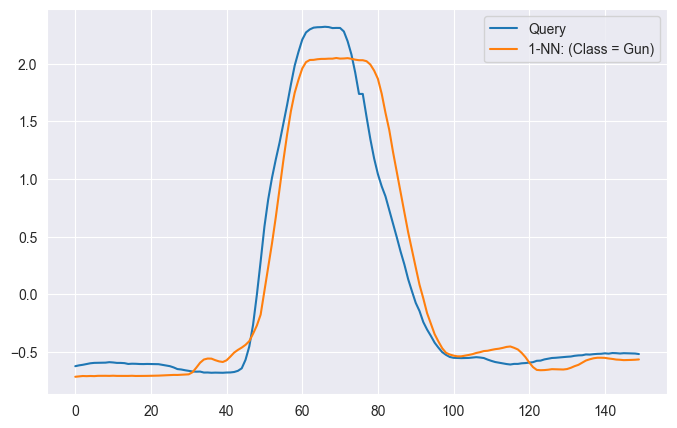

In [51]:
plt.figure(figsize=(8,5))
plt.plot(X_test[12], label = 'Query')
plt.plot(X_train[24], label = '1-NN: (Class = Gun)')
plt.legend()

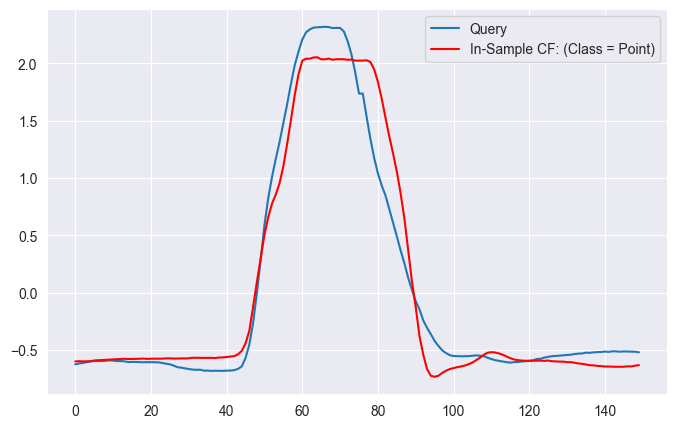

In [52]:
plt.figure(figsize=(8,5))
plt.plot(X_test[12], label = 'Query')
plt.plot(X_train[4], c='red', label='In-Sample CF: (Class = Point)')
plt.legend()

In [53]:
from tslearn.barycenters import dtw_barycenter_averaging

In [54]:
def target_(instance):
    target = np.argsort((model.predict_proba(instance.reshape(1,-1))))[0][-2:-1][0] 
    return target

In [55]:
target_(X_test[5]), y_pred[5]

C:\Users\myz\.conda\envs\ibcfe-tsc\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(0, 1)

### DTW-Case (Simple 1-NN DTW Classifier)

In [56]:
query = X_test[12]
beta = 0
insample_cf = X_train[4]
target = target_(query)
pred_treshold = 0.5

generated_cf = dtw_barycenter_averaging([query, insample_cf], weights=np.array([(1-beta), beta]))

prob_target = model.predict_proba(generated_cf.reshape(1,-1))[0][target]

while prob_target < pred_treshold:
    beta +=0.01 
    generated_cf = generated_cf = dtw_barycenter_averaging([query, insample_cf], weights=np.array([(1-beta), beta]))
    prob_target = model.predict_proba(generated_cf.reshape(1,-1))[0][target]
    

C:\Users\myz\.conda\envs\ibcfe-tsc\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\myz\.conda\envs\ibcfe-tsc\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [57]:
generated_cf

array([[-0.61853129],
       [-0.60639577],
       [-0.60639577],
       [-0.59966944],
       [-0.5962516 ],
       [-0.59575725],
       [-0.59439082],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59010296],
       [-0.59256172],
       [-0.59646199],
       [-0.59848914],
       [-0.60579593],
       [-0.61306201],
       [-0.61306201],
       [-0.61826217],
       [-0.61826217],
       [-0.61826217],
       [-0.61826217],
       [-0.61826217],
       [-0.62470947],
       [-0.62470947],
       [-0.63564075],
       [-0.65715974],
       [-0.67822029],
       [-0.67538348],
       [-0.66523256],
       [-0.64349163],
       [-0.64349163],
       [-0.57019517],
       [-0.57019517],
       [-0

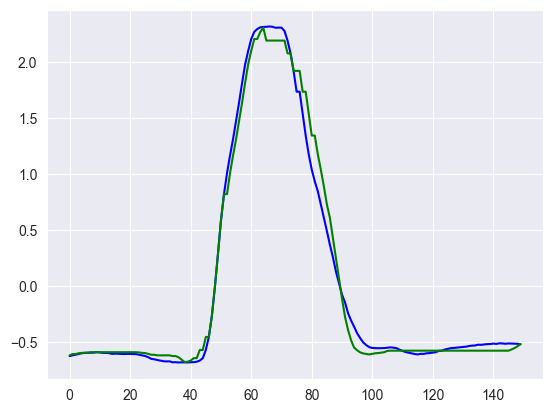

In [58]:
plt.plot(X_test[12], c='blue')
plt.plot(generated_cf, c='green', label='Generated CF: (Class = Point)')

### Plotting This

Text(-4, 2.3, 'C.')

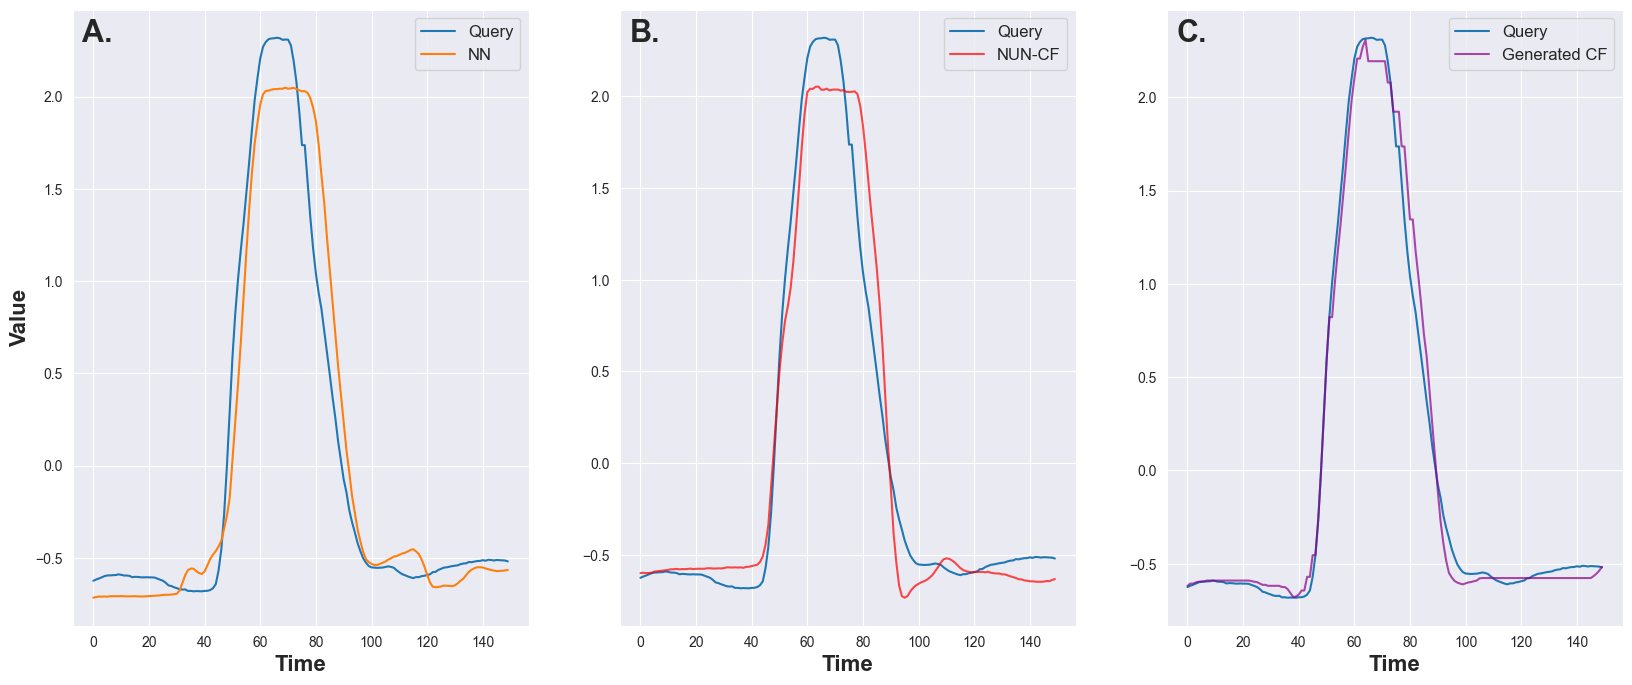

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), facecolor="1")
plt.xlabel('Time')
    
axes[0].plot(X_test[12], label = 'Query')
axes[0].plot(X_train[24], label = 'NN')
axes[0].legend(loc='upper right', fontsize=12) 
axes[0].set_xlabel('Time', rotation=0, size=16, fontweight='bold')
axes[0].set_ylabel('Value', rotation=90, size=16, fontweight='bold')   
    
axes[1].plot(X_test[12], label = 'Query')
axes[1].plot(X_train[4],alpha = 0.7, label = 'NUN-CF', color='red')
axes[1].legend(loc='upper right', fontsize=12)
axes[1].set_xlabel('Time', rotation=0, size=16, fontweight='bold')


axes[2].plot(X_test[12], label = 'Query')
axes[2].plot(generated_cf,alpha = 0.7, label = 'Generated CF', color='darkmagenta')
axes[2].legend(loc='upper right', fontsize=12)
axes[2].set_xlabel('Time', rotation=0, size=16, fontweight='bold')


axes[0].text(-4,2.3,'A.', fontsize=22, fontweight='bold')
axes[1].text(-4,2.3,'B.', fontsize=22, fontweight='bold')
axes[2].text(-4,2.3,'C.', fontsize=22, fontweight='bold')

#plt.savefig('./Images/DTW_DBA_EXAMPLE.pdf')